In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

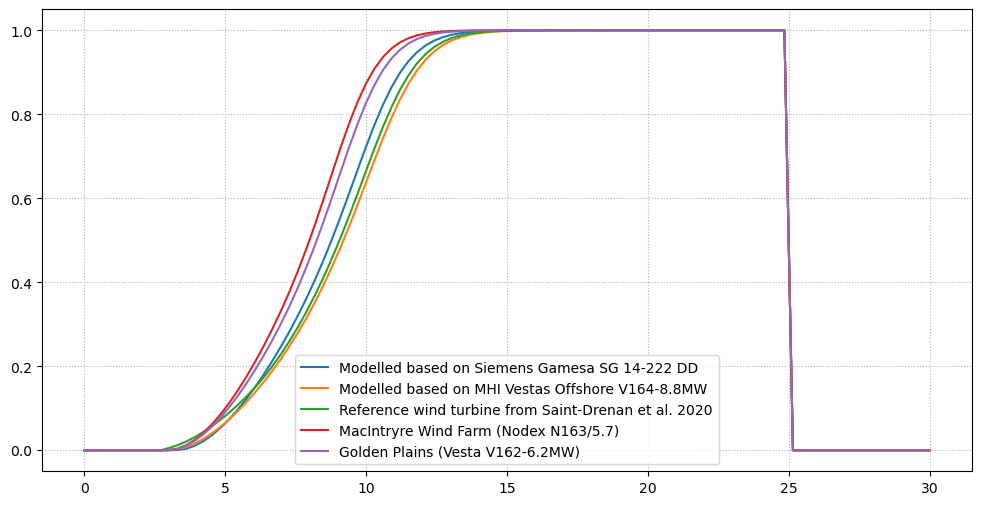

In [3]:
from sea_breeze_analysis.wind_turbine_power_curve import GenericWindTurbinePowerCurve

x = np.linspace(0,30,100)

plt.figure(figsize=[12,6])

Pnom=14000
D=222
plt.plot(x,GenericWindTurbinePowerCurve(x,Pnom,D)/Pnom,label="Modelled based on Siemens Gamesa SG 14-222 DD")

Pnom=8800
D=164
plt.plot(x,GenericWindTurbinePowerCurve(x,Pnom,D)/Pnom,label="Modelled based on MHI Vestas Offshore V164-8.8MW")

Pnom=2000
D=80
plt.plot(x,GenericWindTurbinePowerCurve(x,Pnom,D)/Pnom,label="Reference wind turbine from Saint-Drenan et al. 2020")


Pnom=5700
D=163
plt.plot(x,GenericWindTurbinePowerCurve(x,Pnom,D)/Pnom,label="MacIntryre Wind Farm (Nodex N163/5.7)")


Pnom=6200
D=162
plt.plot(x,GenericWindTurbinePowerCurve(x,Pnom,D)/Pnom,label="Golden Plains (Vesta V162-6.2MW)")

# Pnom=10000
# D=180
# plt.plot(x,GenericWindTurbinePowerCurve(x,Pnom,D)/Pnom)


plt.gca().grid(ls=":")
plt.legend()

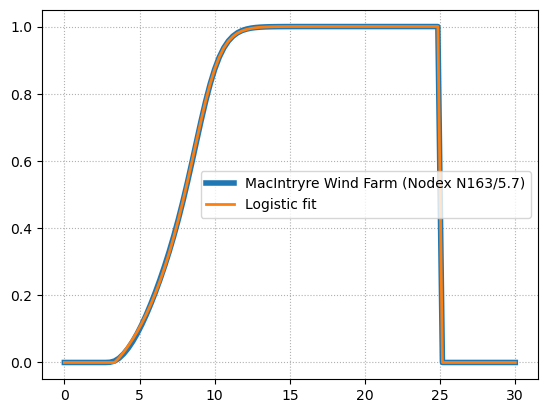

In [27]:
from sea_breeze_analysis.wind_turbine_power_curve import capacity_factor

Pnom=5700
D=163
plt.plot(x,GenericWindTurbinePowerCurve(x,Pnom,D)/Pnom,label="MacIntryre Wind Farm (Nodex N163/5.7)",lw=4)
plt.plot(x,capacity_factor(x,Pnom=Pnom,D=D),label="Logistic fit",lw=2)
plt.legend()
plt.gca().grid(ls=":")

In [10]:
from dask.distributed import Client
client = Client()
client

/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45013 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/45013/status,
Dashboard: /proxy/45013/status,Workers: 7
Total threads: 14,Total memory: 63.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44753,Workers: 7
Dashboard: /proxy/45013/status,Total threads: 14
Started: Just now,Total memory: 63.00 GiB
Comm: tcp://127.0.0.1:39573,Total threads: 2
Dashboard: /proxy/42651/status,Memory: 9.00 GiB
Nanny: tcp://127.0.0.1:40441,


In [13]:
from sea_breeze import utils, load_model_data

t1 = "2020-01-01 00:00"
t2 = "2020-12-31 23:00"
u_var="ua100m"
v_var="va100m"
lat_slice, lon_slice = utils.get_aus_bounds()  

u = load_model_data.load_barra_variable(
    u_var,
    t1,
    t2,
    "AUST-04",
    "1hr",
    lat_slice,
    lon_slice,
    chunks={"time":-1,"lat":{},"lon":{}})
v = load_model_data.load_barra_variable(
    v_var,
    t1,
    t2,
    "AUST-04",
    "1hr",
    lat_slice,
    lon_slice,
    chunks={"time":-1,"lat":{},"lon":{}})

In [14]:
ws = np.sqrt(u**2 + v**2)
cf = capacity_factor(ws)

In [16]:
cf_mean = cf.mean("time").persist()

/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 12.72 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


In [20]:
lat_slice, lon_slice = utils.get_aus_bounds()
angle_ds = load_model_data.get_coastline_angle_kernel(
    compute=False,
    path_to_load="/g/data/ng72/ab4502/coastline_data/barra_c.nc",
    lat_slice=lat_slice,
    lon_slice=lon_slice)
_,lsm = load_model_data.load_barra_static("AUST-04",lon_slice,lat_slice)
min_coast_dist = xr.where(lsm,angle_ds.min_coast_dist,-angle_ds.min_coast_dist)

In [23]:
cf_mean_masked = xr.where(min_coast_dist<-300,np.nan,cf_mean).persist()

/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 9.82 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


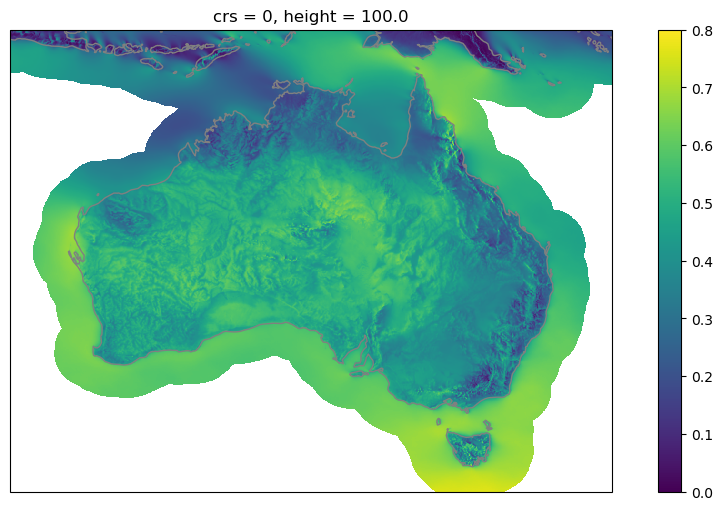

In [25]:
import cartopy.crs as ccrs

plt.figure(figsize=[12,6])
ax=plt.axes(projection=ccrs.PlateCarree())
cf_mean_masked.plot(vmin=0,vmax=0.8)
ax.coastlines(color="grey")